In [ ]:
!cp ./drive/MyDrive/train_sub100w.txt ./train.txt
!cp ./drive/MyDrive/test_sub100w.txt ./test.txt
!head -n 500000 ./train.txt > train_sub.txt

In [ ]:
# Load you git and add to path
import sys
sys.path.append("/content/drive/MyDrive")

In [ ]:
!rm -rf CTR_Models/
!git clone https://github.com/scarlet25151/CTR_Models.git

Cloning into 'CTR_Models'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 96 (delta 32), reused 76 (delta 15), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [ ]:
from io import StringIO

import torch
import pandas as pd

from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import History

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from CTR_Models.models import IFM, AFM
from CTR_Models.utils import SparseFeat, DenseFeat, get_feature_names

In [ ]:
device = torch.device("cuda:0")
path = './train_sub.txt'

In [ ]:
def process_input(path, encoding='utf-8', use_densefeat=True, test_size=0.2):
    with open(path, encoding='utf-8') as f:
        contents = f.read()

    names = ['label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13',
             'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
             'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22',
             'C23', 'C24', 'C25', 'C26']
    data = pd.read_csv(StringIO(contents), sep='\t', header=None, names=names)

    sparse_features = ['C' + str(i) for i in range(1, 27)]
    dense_features = ['I' + str(i) for i in range(1, 14)]

    data[sparse_features] = data[sparse_features].fillna('-1', )
    data[dense_features] = data[dense_features].fillna(0, )

    for feat in sparse_features:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
    mms = MinMaxScaler(feature_range=(0, 1))
    data[dense_features] = mms.fit_transform(data[dense_features])

    if use_densefeat:
        fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                                  for i, feat in enumerate(sparse_features)] + [DenseFeat(feat, 1, )
                                                                                for feat in dense_features]
    else:
        fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                                  for i, feat in enumerate(sparse_features)]

    dnn_feature_columns = fixlen_feature_columns
    linear_feature_columns = fixlen_feature_columns

    feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

    train, test = train_test_split(data, test_size=0.2, random_state=1337)
    train_model_input = {name: train[name] for name in feature_names}
    test_model_input = {name: test[name] for name in feature_names}
    
    return (linear_feature_columns, dnn_feature_columns), (train_model_input, test_model_input), (train, test)

In [ ]:
(linear_feature_columns, dnn_feature_columns), (train_model_input, test_model_input), (train, test) = process_input(path, use_densefeat=False)

fm_model = AFM(linear_feature_columns, dnn_feature_columns, task='binary', device='cuda:0', use_attention=False,
               l2_reg_embedding=0.001, l2_reg_linear=0.001, )

In [ ]:
earlyStopping = EarlyStopping(monitor='loss', min_delta=0.001)

fm_model.compile("adam", "binary_crossentropy",
                metrics=["binary_crossentropy", "accuracy", "auc"], )
target = ['label']

fm_history = fm_model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=50, verbose=2, validation_split=0.2,callbacks=[earlyStopping, ], )
fm_pred_ans = fm_model.predict(test_model_input, batch_size=256)

cuda:0
Train on 320000 samples, validate on 80000 samples, 1250 steps per epoch
Epoch 1/50
37s - loss:  0.5120 - binary_crossentropy:  0.5098 - accuracy:  0.7617 - auc:  0.7213 - val_binary_crossentropy:  0.4922 - val_accuracy:  0.7676 - val_auc:  0.7437
Epoch 2/50
37s - loss:  0.4510 - binary_crossentropy:  0.4415 - accuracy:  0.7992 - auc:  0.8110 - val_binary_crossentropy:  0.4995 - val_accuracy:  0.7638 - val_auc:  0.7401
Epoch 3/50
37s - loss:  0.4071 - binary_crossentropy:  0.3895 - accuracy:  0.8316 - auc:  0.8595 - val_binary_crossentropy:  0.5159 - val_accuracy:  0.7597 - val_auc:  0.7325
Epoch 4/50
37s - loss:  0.3757 - binary_crossentropy:  0.3518 - accuracy:  0.8523 - auc:  0.8881 - val_binary_crossentropy:  0.5334 - val_accuracy:  0.7551 - val_auc:  0.7277
Epoch 5/50
37s - loss:  0.3556 - binary_crossentropy:  0.3277 - accuracy:  0.8633 - auc:  0.9043 - val_binary_crossentropy:  0.5489 - val_accuracy:  0.7492 - val_auc:  0.7233
Epoch 6/50
37s - loss:  0.3416 - binary_cross

In [ ]:
print("test LogLoss", round(log_loss(test[target].values, fm_pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, fm_pred_ans), 4))
print("test accuracy", round(average_precision_score(test[target].values, fm_pred_ans), 4))

test LogLoss 0.6896
test AUC 0.6997
test accuracy 0.4425


dict_keys(['loss', 'binary_crossentropy', 'accuracy', 'auc', 'val_binary_crossentropy', 'val_accuracy', 'val_auc'])


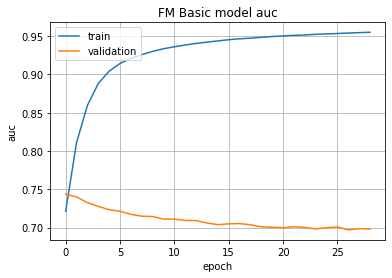

In [ ]:
print(fm_history.history.keys())
plt.plot(fm_history.history['auc'])
plt.plot(fm_history.history['val_auc'])
plt.title('FM Basic model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

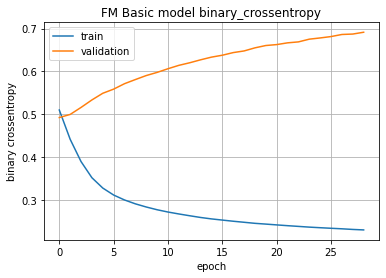

In [ ]:
plt.plot(fm_history.history['binary_crossentropy'])
plt.plot(fm_history.history['val_binary_crossentropy'])
plt.title('FM Basic model binary_crossentropy')
plt.ylabel('binary crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
(linear_feature_columns, dnn_feature_columns), (train_model_input, test_model_input), (train, test) = process_input(path, use_densefeat=False)

afm_model = AFM(linear_feature_columns, dnn_feature_columns, task='binary', device='cuda:0', 
                l2_reg_embedding=0.001, l2_reg_linear=0.001, afm_dropout=0.2,)

In [ ]:
earlyStopping = EarlyStopping(monitor='loss', min_delta=0.001)

afm_model.compile("adam", "binary_crossentropy",
                metrics=["binary_crossentropy", "accuracy", "auc"], )
target = ['label']

afm_history = afm_model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=100, verbose=2, validation_split=0.2, callbacks=[earlyStopping,  ] )
afm_pred_ans = afm_model.predict(test_model_input, batch_size=256)

cuda:0
Train on 320000 samples, validate on 80000 samples, 1250 steps per epoch
Epoch 1/100
46s - loss:  0.5204 - binary_crossentropy:  0.5193 - accuracy:  0.7550 - auc:  0.7110 - val_binary_crossentropy:  0.4978 - val_accuracy:  0.7655 - val_auc:  0.7355
Epoch 2/100
46s - loss:  0.4798 - binary_crossentropy:  0.4757 - accuracy:  0.7747 - auc:  0.7753 - val_binary_crossentropy:  0.4914 - val_accuracy:  0.7682 - val_auc:  0.7442
Epoch 3/100
46s - loss:  0.4638 - binary_crossentropy:  0.4563 - accuracy:  0.7862 - auc:  0.8023 - val_binary_crossentropy:  0.4897 - val_accuracy:  0.7682 - val_auc:  0.7462
Epoch 4/100
46s - loss:  0.4541 - binary_crossentropy:  0.4433 - accuracy:  0.7942 - auc:  0.8185 - val_binary_crossentropy:  0.4893 - val_accuracy:  0.7686 - val_auc:  0.7472
Epoch 5/100
46s - loss:  0.4478 - binary_crossentropy:  0.4339 - accuracy:  0.8008 - auc:  0.8292 - val_binary_crossentropy:  0.4896 - val_accuracy:  0.7692 - val_auc:  0.7472
Epoch 6/100
46s - loss:  0.4435 - binary

In [ ]:
print("test LogLoss", round(log_loss(test[target].values, afm_pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, afm_pred_ans), 4))
print("test accuracy", round(average_precision_score(test[target].values, afm_pred_ans), 4))

test LogLoss 0.4919
test AUC 0.7477
test accuracy 0.5134


dict_keys(['loss', 'binary_crossentropy', 'accuracy', 'auc', 'val_binary_crossentropy', 'val_accuracy', 'val_auc'])


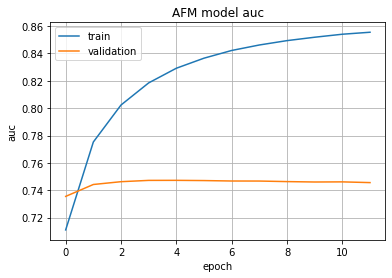

In [ ]:
print(afm_history.history.keys())
plt.plot(afm_history.history['auc'])
plt.plot(afm_history.history['val_auc'])
plt.title('AFM model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

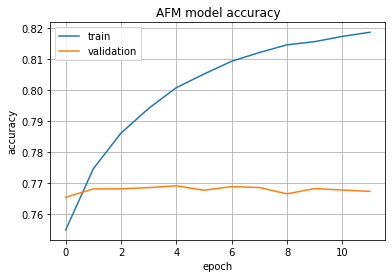

In [ ]:
plt.plot(afm_history.history['accuracy'])
plt.plot(afm_history.history['val_accuracy'])
plt.title('AFM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
(linear_feature_columns, dnn_feature_columns), (train_model_input, test_model_input), (train, test) = process_input(path)
ifm_model = IFM(linear_feature_columns, dnn_feature_columns, task='binary', l2_reg_embedding=0.001, l2_reg_linear=0.001,
                l2_reg_dnn=0.001, dnn_dropout=0.3, dnn_use_bn= True, device="cuda:0")

In [ ]:
earlyStopping = EarlyStopping(monitor='loss', min_delta=0.001)

ifm_model.compile("adam", "binary_crossentropy",
                metrics=["binary_crossentropy", "accuracy", "auc"], )
target = ['label']

ifm_history = ifm_model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=50, verbose=2, validation_split=0.2, callbacks=[earlyStopping,] )
ifm_pred_ans = ifm_model.predict(test_model_input, batch_size=256)

cuda:0
Train on 320000 samples, validate on 80000 samples, 1250 steps per epoch
Epoch 1/50
42s - loss:  0.5075 - binary_crossentropy:  0.5054 - accuracy:  0.7626 - auc:  0.7264 - val_binary_crossentropy:  0.4883 - val_accuracy:  0.7697 - val_auc:  0.7499
Epoch 2/50
42s - loss:  0.3747 - binary_crossentropy:  0.3680 - accuracy:  0.8399 - auc:  0.8755 - val_binary_crossentropy:  0.5551 - val_accuracy:  0.7390 - val_auc:  0.7183
Epoch 3/50
42s - loss:  0.3205 - binary_crossentropy:  0.3107 - accuracy:  0.8656 - auc:  0.9121 - val_binary_crossentropy:  0.5915 - val_accuracy:  0.7556 - val_auc:  0.6979
Epoch 4/50
42s - loss:  0.2733 - binary_crossentropy:  0.2623 - accuracy:  0.8833 - auc:  0.9371 - val_binary_crossentropy:  0.7242 - val_accuracy:  0.7563 - val_auc:  0.6759
Epoch 5/50
42s - loss:  0.2461 - binary_crossentropy:  0.2347 - accuracy:  0.8958 - auc:  0.9496 - val_binary_crossentropy:  0.7761 - val_accuracy:  0.7499 - val_auc:  0.6736
Epoch 6/50
42s - loss:  0.2285 - binary_cross

In [ ]:
print("test LogLoss", round(log_loss(test[target].values, ifm_pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, ifm_pred_ans), 4))
print("test accuracy", round(average_precision_score(test[target].values, ifm_pred_ans), 4))

test LogLoss 1.084
test AUC 0.6671
test accuracy 0.4069


dict_keys(['loss', 'binary_crossentropy', 'accuracy', 'auc', 'val_binary_crossentropy', 'val_accuracy', 'val_auc'])


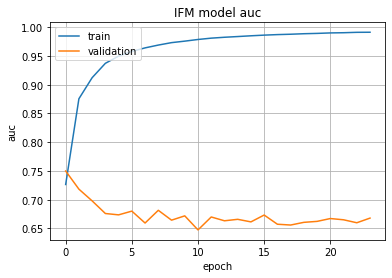

In [ ]:
print(ifm_history.history.keys())
plt.plot(ifm_history.history['auc'])
plt.plot(ifm_history.history['val_auc'])
plt.title('IFM model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

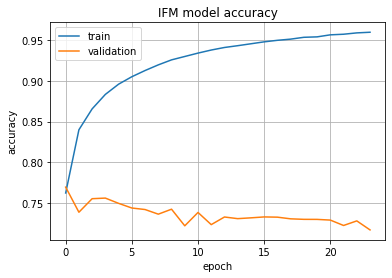

In [ ]:
plt.plot(ifm_history.history['accuracy'])
plt.plot(ifm_history.history['val_accuracy'])
plt.title('IFM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

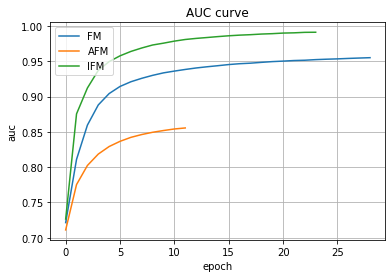

In [ ]:
plt.plot(fm_history.history['auc'])
plt.plot(afm_history.history['auc'])
plt.plot(ifm_history.history['auc'])
plt.ylabel('auc')
plt.xlabel('epoch')
plt.title('AUC curve')
plt.legend(['FM', 'AFM', 'IFM'], loc='upper left')
plt.grid()

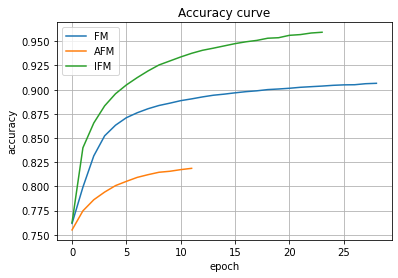

In [ ]:
plt.plot(fm_history.history['accuracy'])
plt.plot(afm_history.history['accuracy'])
plt.plot(ifm_history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Accuracy curve')
plt.legend(['FM', 'AFM', 'IFM'], loc='upper left')
plt.grid()

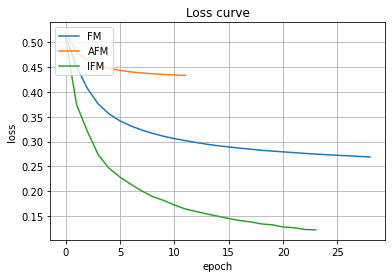

In [ ]:
plt.plot(fm_history.history['loss'])
plt.plot(afm_history.history['loss'])
plt.plot(ifm_history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Loss curve')
plt.legend(['FM', 'AFM', 'IFM'], loc='upper left')
plt.grid()

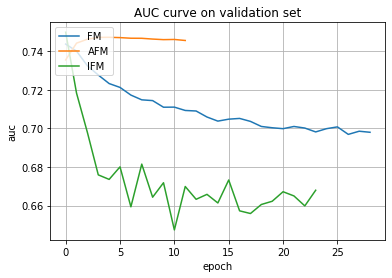

In [ ]:
plt.plot(fm_history.history['val_auc'])
plt.plot(afm_history.history['val_auc'])
plt.plot(ifm_history.history['val_auc'])
plt.ylabel('auc')
plt.xlabel('epoch')
plt.title('AUC curve on validation set')
plt.legend(['FM', 'AFM', 'IFM'], loc='upper left')
plt.grid()

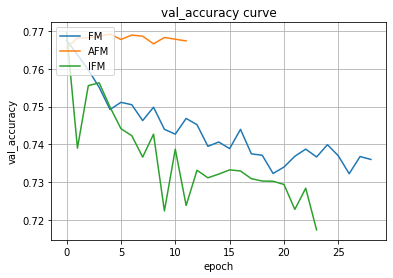

In [ ]:
plt.plot(fm_history.history['val_accuracy'])
plt.plot(afm_history.history['val_accuracy'])
plt.plot(ifm_history.history['val_accuracy'])
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.title('val_accuracy curve')
plt.legend(['FM', 'AFM', 'IFM'], loc='upper left')
plt.grid()

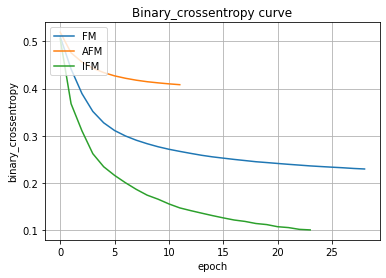

In [ ]:
plt.plot(fm_history.history['binary_crossentropy'])
plt.plot(afm_history.history['binary_crossentropy'])
plt.plot(ifm_history.history['binary_crossentropy'])
plt.ylabel('binary_crossentropy')
plt.xlabel('epoch')
plt.title('Binary_crossentropy curve')
plt.legend(['FM', 'AFM', 'IFM'], loc='upper left')
plt.grid()

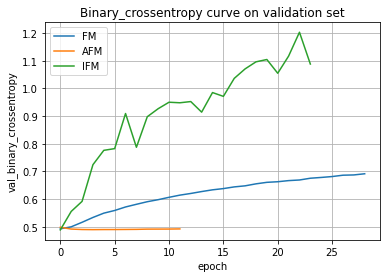

In [ ]:
plt.plot(fm_history.history['val_binary_crossentropy'])
plt.plot(afm_history.history['val_binary_crossentropy'])
plt.plot(ifm_history.history['val_binary_crossentropy'])
plt.ylabel('val_binary_crossentropy')
plt.xlabel('epoch')
plt.title('Binary_crossentropy curve on validation set')
plt.legend(['FM', 'AFM', 'IFM'], loc='upper left')
plt.grid()